# HSMA Exercise

The data loaded in this exercise is for seven acute stroke units, and whether a patient receives clost-busting treatment for stroke.  There are lots of features, and a description of the features can be found in the file stroke_data_feature_descriptions.csv.

Train a Neural Network model to try to predict whether or not a stroke patient receives clot-busting treatment.  Use the prompts below to write each section of code.

How accurate can you get your model on the test set?

Calculate training and test set accuracy of your model.

In [15]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# sklearn for pre-processing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

# TensorFlow sequential model
from tensorflow import keras
from tensorflow.keras import backend as K
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras.optimizers import Adam

# Download data 
# (not required if running locally and have previously downloaded data)

download_required = True

if download_required:
    
    # Download processed data:
    address = 'https://raw.githubusercontent.com/MichaelAllen1966/' + \
                '2004_titanic/master/jupyter_notebooks/data/hsma_stroke.csv'        
    data = pd.read_csv(address)

    # Create a data subfolder if one does not already exist
    import os
    data_directory ='./data/'
    if not os.path.exists(data_directory):
        os.makedirs(data_directory)

    # Save data to data subfolder
    data.to_csv(data_directory + 'hsma_stroke.csv', index=False)



data = data.astype(float)
X = data.drop('Clotbuster given',axis=1) # X = all 'data' except the 'survived' column
y = data['Clotbuster given'] # y = 'survived' column from 'data'
# Convert to NumPy as required for k-fold splits
X_np = X.values
y_np = y.values

# Split data
X_train, X_test, y_train, y_test = train_test_split(
    X_np, y_np, test_size = 0.25, random_state=42)



In [16]:
def scale_data(X_train, X_test):
    """Scale data 0-1 based on min and max in training set"""
    
    # Initialise a new scaling object for normalising input data
    sc = MinMaxScaler()

    # Apply the scaler to the training and test sets
    train_sc = sc.fit_transform(X_train)
    test_sc = sc.fit_transform(X_test)
    
    return train_sc, test_sc

Plot training and test set accuracy over time during fitting.

In [39]:
def calculate_accuracy(model, X_train_sc, X_test_sc, y_train, y_test):
    """Calculate and print accuracy of training and test data fits"""    
    
    ### Get accuracy of fit to training data
    probability = model.predict(X_train_sc)
    y_pred_train = probability >= 0.5
    y_pred_train = y_pred_train.flatten()
    accuracy_train = np.mean(y_pred_train == y_train)
    
    ### Get accuracy of fit to test data
    probability = model.predict(X_test_sc)
    y_pred_test = probability >= 0.5
    y_pred_test = y_pred_test.flatten()
    accuracy_test = np.mean(y_pred_test == y_test)
  
    
    # Show accuracy
    print (f'Training accuracy {accuracy_train:0.3f}')
    print (f'Test accuracy {accuracy_test:0.3f}')
    return accuracy_test

    
def plot_training(history_dict, title = 'Training and validation accuracy'):
    acc_values = history_dict['accuracy']
    val_acc_values = history_dict['val_accuracy']
    epochs = range(1, len(acc_values) + 1)

    fig, ax = plt.subplots()

    ax.set_xlabel('Time')
    ax.set_ylabel('Accuracy')

    ax.plot(epochs, acc_values, color='blue', label='Training acc')
    ax.plot(epochs, val_acc_values, color='red', label='Test accuracy')
    ax.set_title(title)
    
    ax.legend()

    fig.show()

Scale data before fitting the model.

In [22]:
# Scale X data
X_train_sc, X_test_sc = scale_data(X_train, X_test)

In [23]:
def make_net(number_features, 
            hidden_layers=3, 
            hidden_layer_neurones=128, 
            dropout=0.0, 
            learning_rate=0.003):
    
    """Make TensorFlow neural net"""
    
    # Clear Tensorflow 
    K.clear_session()
    
    # Set up neural net
    net = Sequential()
    
    # Add hidden hidden_layers using a loop
    for i in range(hidden_layers):
        # Add fully connected layer with ReLu activation
        net.add(Dense(
            hidden_layer_neurones, 
            input_dim=number_features,
            activation='relu'))
        # Add droput layer
        net.add(Dropout(dropout))
    
    # Add final sigmoid activation output
    net.add(Dense(1, activation='sigmoid'))    
    
    # Compiling model
    opt = Adam(learning_rate=learning_rate)
    
    net.compile(loss='binary_crossentropy', 
                optimizer=opt, 
                metrics=['accuracy'])
    
    return net

Now try different things in your model to improve test accuracy.  You might consider :
- Reducing overfitting if overfitting is a problem.
- Changing the number of hidden layers
- Changing the number of hidden neurons
- Changing batch size
- Changing dropout rate
- Changing the learning rate
- Changing the train / test split
- Trying stratified k-fold validation
- Dropping features

or more!

Tip : keep your analysis above as your base case.  Then below, just use the functions you've built to rebuild and retrain models with different parameters (or run altered versions of other cells below).  Don't forget, you need to build and train again before you get new outputs.

Add comments to your code to explain what you've changed, and change things a bit at a time (don't change everything all at once!)

/opt/homebrew/Caskroom/miniconda/base/envs/tf_hsma/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 694us/step
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 315us/step
Training accuracy 0.862
Test accuracy 0.798


/var/folders/cf/hfdshtps1bzbtzd3txx2ybmr0000gn/T/ipykernel_62445/3036535180.py:36: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


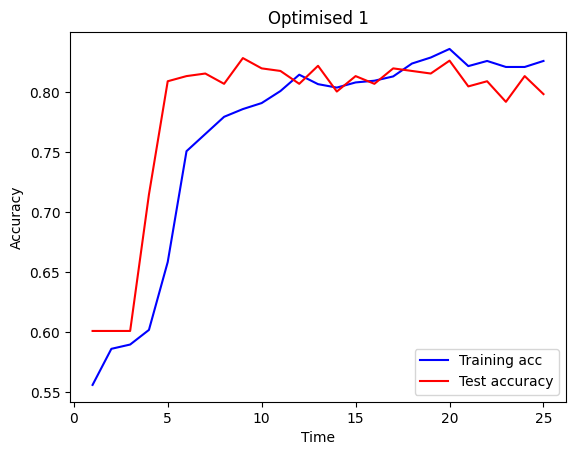

In [24]:
# Define save checkpoint callback (only save if new best validation results)
checkpoint_cb = keras.callbacks.ModelCheckpoint(
    'model_checkpoint.keras', save_best_only=True)

# Define early stopping callback
# Stop when no validation improvement for 25 epochs
# Restore weights to best validation accuracy
early_stopping_cb = keras.callbacks.EarlyStopping(
    patience=25, restore_best_weights=True)



# Define network
number_features = X_train_sc.shape[1]
model = make_net(number_features, 
                hidden_layers=5, 
                hidden_layer_neurones=64, 
                dropout=0.5, 
                learning_rate=0.003)

### Train model (and store training info in history)
history = model.fit(X_train_sc,
                    y_train,
                    epochs=25,
                    batch_size=64,
                    validation_data=(X_test_sc, y_test),
                    verbose=0)

plot_training(history.history, title = "Optimised 1")

calculate_accuracy(model, X_train_sc, X_test_sc, y_train, y_test)

model.save('clot_optimised1.keras')

44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 756us/step
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 349us/step
Training accuracy 0.840
Test accuracy 0.828


/var/folders/cf/hfdshtps1bzbtzd3txx2ybmr0000gn/T/ipykernel_62445/3036535180.py:36: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


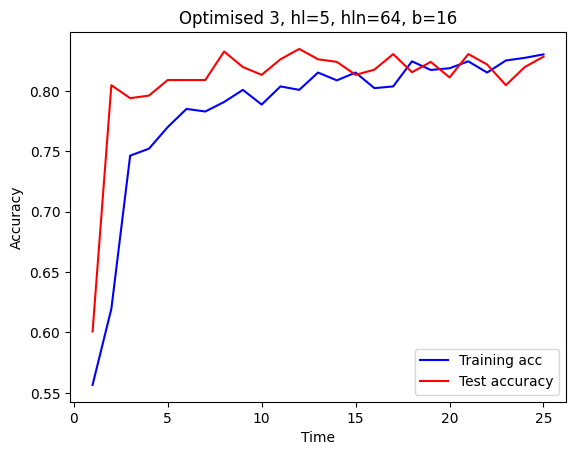

In [25]:
# Parameters
epochs = 25
batch_size=16
hidden_layers=5 
hidden_layer_neurones=64
dropout=0.5
learning_rate=0.003

# Define save checkpoint callback (only save if new best validation results)
checkpoint_cb = keras.callbacks.ModelCheckpoint(
    'model_checkpoint.keras', save_best_only=True)

# Define early stopping callback
# Stop when no validation improvement for 25 epochs
# Restore weights to best validation accuracy
early_stopping_cb = keras.callbacks.EarlyStopping(
    patience=25, restore_best_weights=True)



# Define network
number_features = X_train_sc.shape[1]
model = make_net(number_features, 
                hidden_layers=hidden_layers, 
                hidden_layer_neurones= hidden_layer_neurones, 
                dropout=dropout, 
                learning_rate=learning_rate)

### Train model (and store training info in history)
history = model.fit(X_train_sc,
                    y_train,
                    epochs=epochs,
                    batch_size=batch_size,
                    validation_data=(X_test_sc, y_test),
                    verbose=0)

plot_training(history.history, 
title = f"Optimised 3, hl={hidden_layers}, hln={hidden_layer_neurones}, b={batch_size}")

calculate_accuracy(model, X_train_sc, X_test_sc, y_train, y_test)

model.save('clot_optimised3.keras')

/opt/homebrew/Caskroom/miniconda/base/envs/tf_hsma/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 690us/step
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 308us/step
Training accuracy 0.845
Test accuracy 0.809


/var/folders/cf/hfdshtps1bzbtzd3txx2ybmr0000gn/T/ipykernel_62445/3036535180.py:36: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


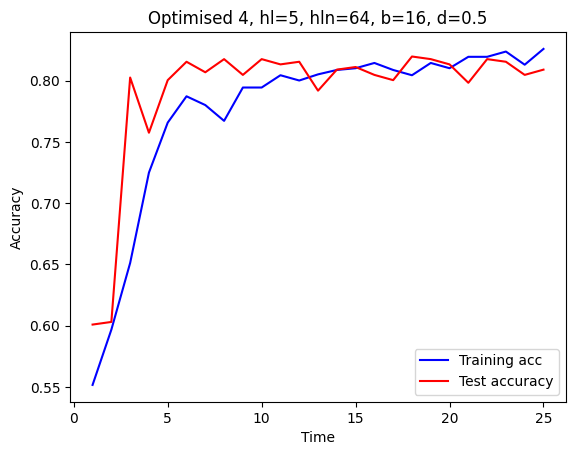

In [28]:
# Parameters
epochs = 25
batch_size=16
hidden_layers=5 
hidden_layer_neurones=64
dropout=0.5
learning_rate=0.003

# Define save checkpoint callback (only save if new best validation results)
checkpoint_cb = keras.callbacks.ModelCheckpoint(
    'model_checkpoint.keras', save_best_only=True)

# Define early stopping callback
# Stop when no validation improvement for 25 epochs
# Restore weights to best validation accuracy
early_stopping_cb = keras.callbacks.EarlyStopping(
    patience=25, restore_best_weights=True)



# Define network
number_features = X_train_sc.shape[1]
model = make_net(number_features, 
                hidden_layers=hidden_layers, 
                hidden_layer_neurones= hidden_layer_neurones, 
                dropout=dropout, 
                learning_rate=learning_rate)

### Train model (and store training info in history)
history = model.fit(X_train_sc,
                    y_train,
                    epochs=epochs,
                    batch_size=batch_size,
                    validation_data=(X_test_sc, y_test),
                    verbose=0)

plot_training(history.history, 
title = f"Optimised 4, hl={hidden_layers}, hln={hidden_layer_neurones}, b={batch_size}, d={dropout}")

calculate_accuracy(model, X_train_sc, X_test_sc, y_train, y_test)

model.save('clot_optimised4.keras')

/opt/homebrew/Caskroom/miniconda/base/envs/tf_hsma/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 744us/step
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 325us/step
Training accuracy 0.844
Test accuracy 0.824


/var/folders/cf/hfdshtps1bzbtzd3txx2ybmr0000gn/T/ipykernel_62445/3036535180.py:36: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 675us/step
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 320us/step
Training accuracy 0.850
Test accuracy 0.822
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 715us/step
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 326us/step
Training accuracy 0.843
Test accuracy 0.792
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 708us/step
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 344us/step
Training accuracy 0.836
Test accuracy 0.815
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 674us/step
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 316us/step
Training accuracy 0.838
Test accuracy 0.820
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 703us/step
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 344us/step
Training accuracy 0.862
Test accuracy 0.813
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 686us/step
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 314us/step
Training accuracy 0.864
Test accuracy 0.826
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 679us/step
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 307us/step
Training accuracy 0.867
Test accuracy 0.805
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 660us/step
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 331us/step
Training accuracy 0.868
Test accurac

/var/folders/cf/hfdshtps1bzbtzd3txx2ybmr0000gn/T/ipykernel_62445/3036535180.py:25: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, ax = plt.subplots()


44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 663us/step
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 279us/step
Training accuracy 0.856
Test accuracy 0.818
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 662us/step
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 323us/step
Training accuracy 0.876
Test accuracy 0.805
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 722us/step
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 364us/step
Training accuracy 0.845
Test accuracy 0.809
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 698us/step
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 327us/step
Training accuracy 0.878
Test accuracy 0.800
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 747us/step
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 362us/step
Training accuracy 0.869
Test accuracy 0.824


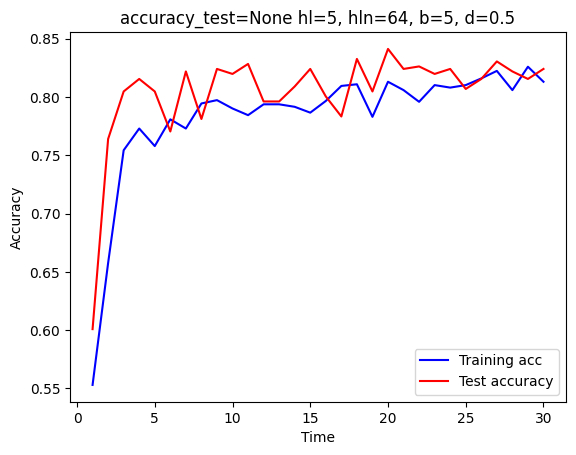

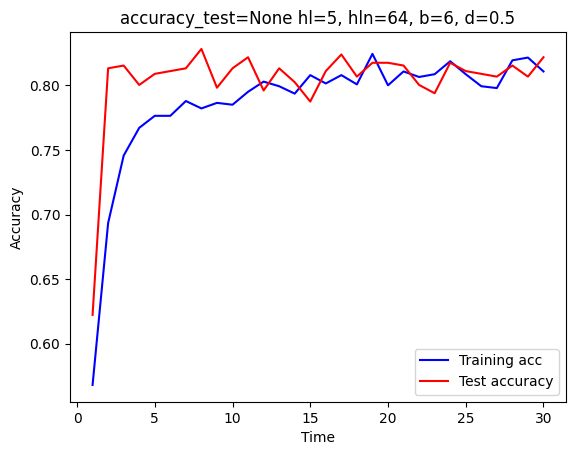

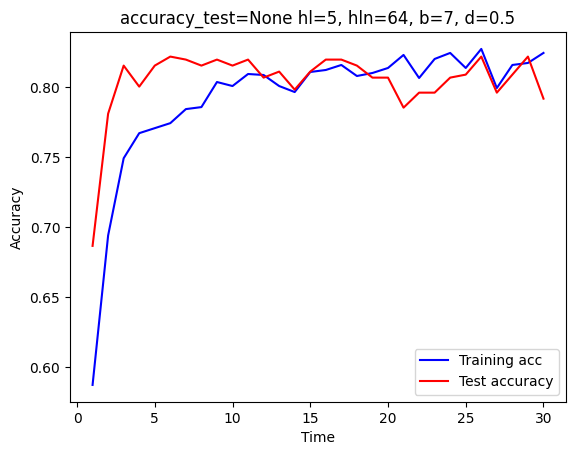

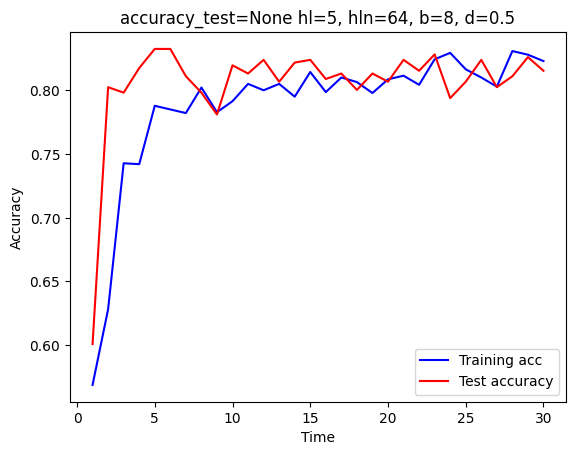

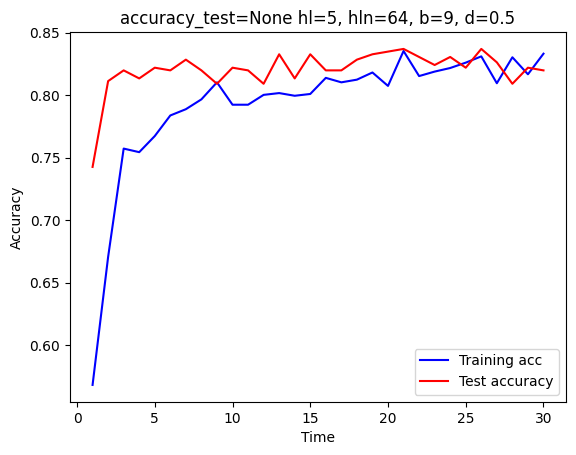

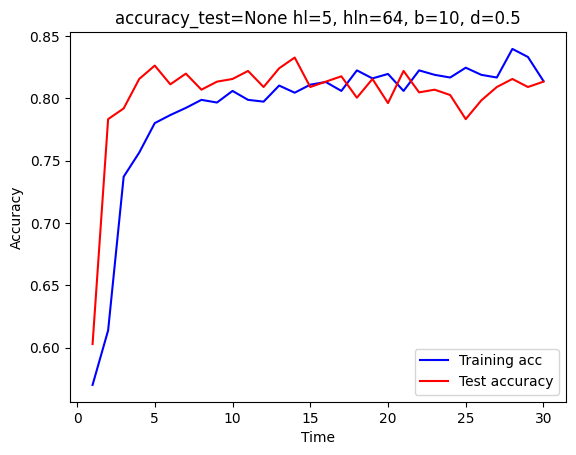

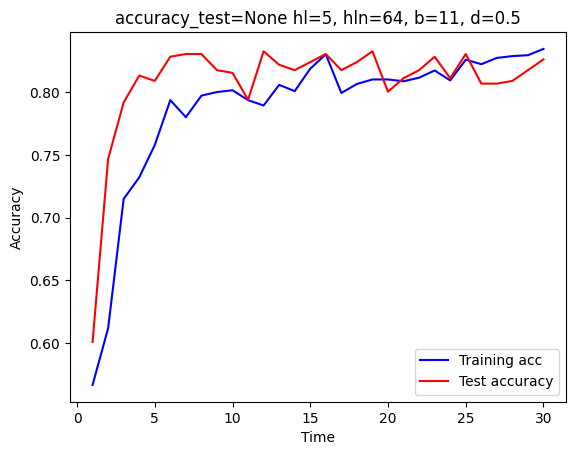

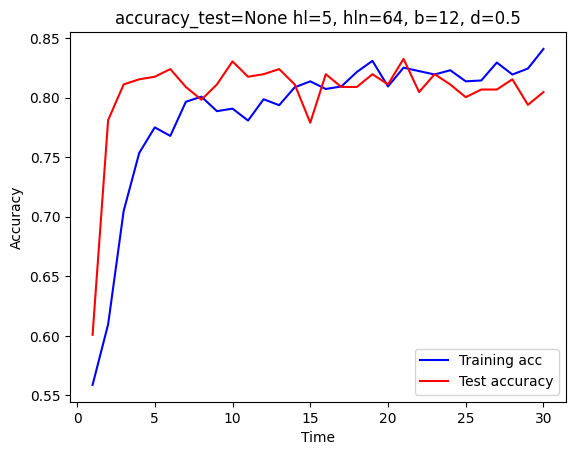

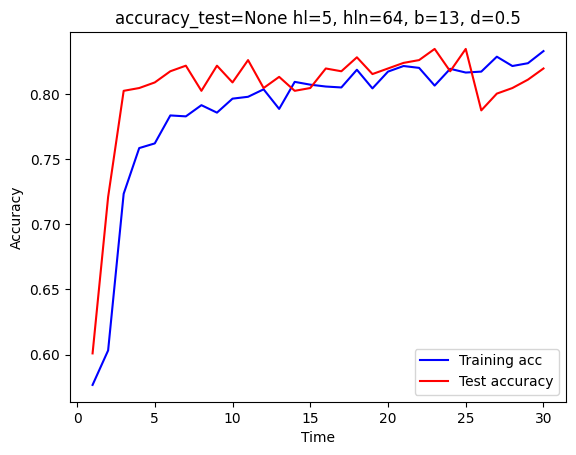

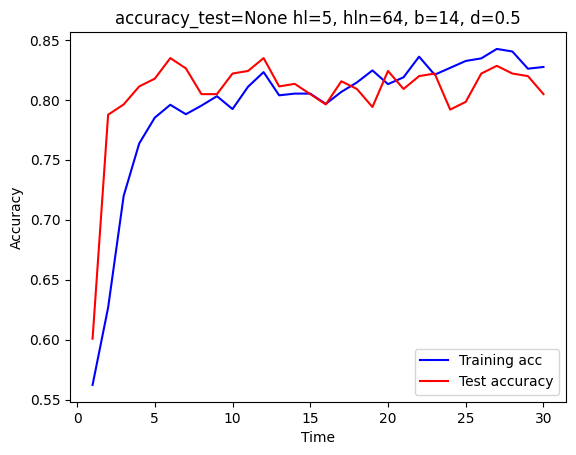

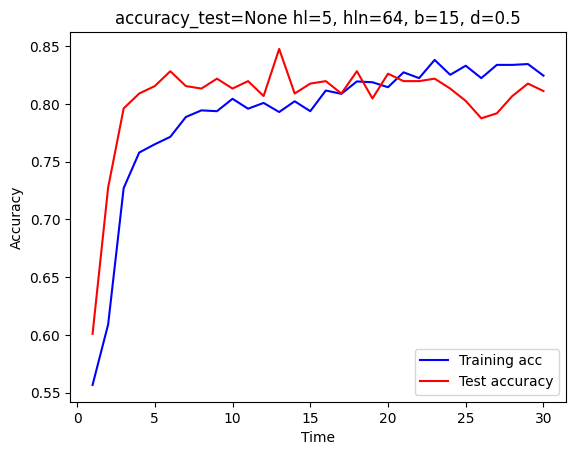

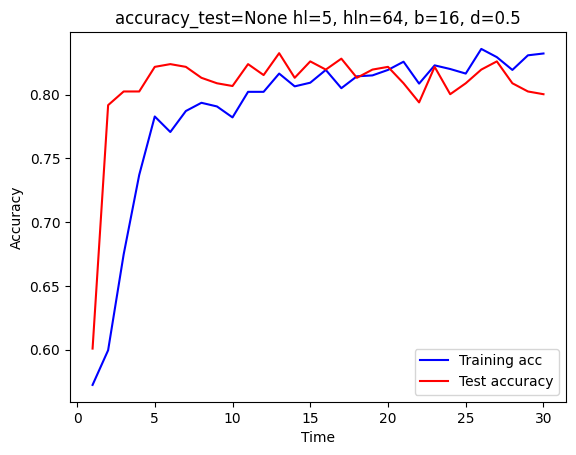

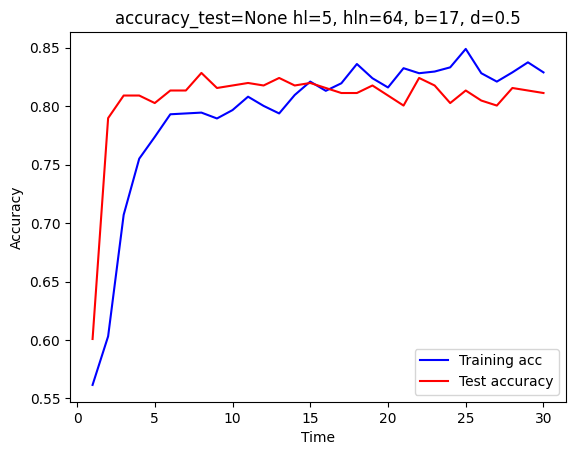

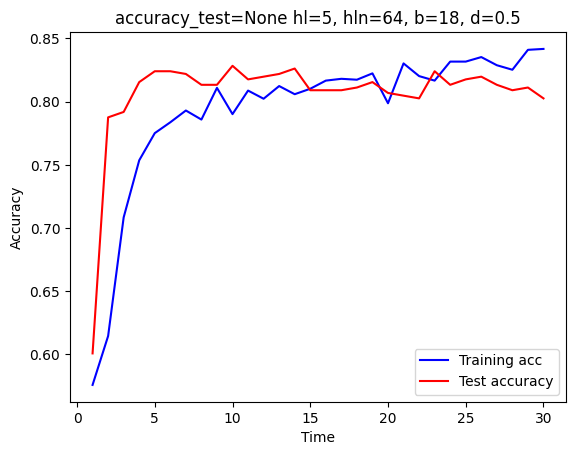

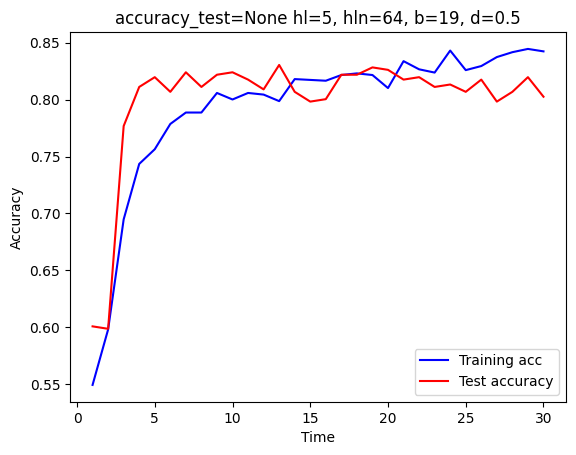

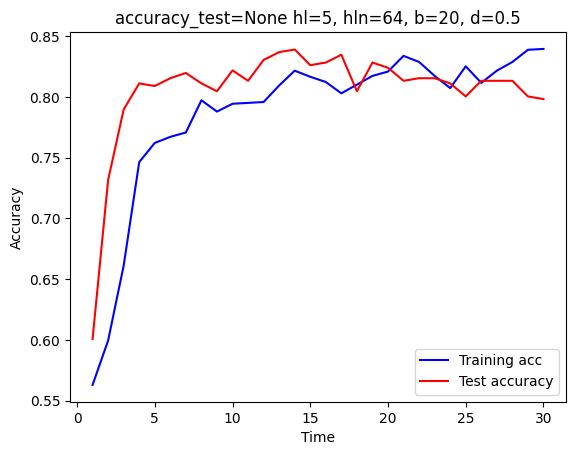

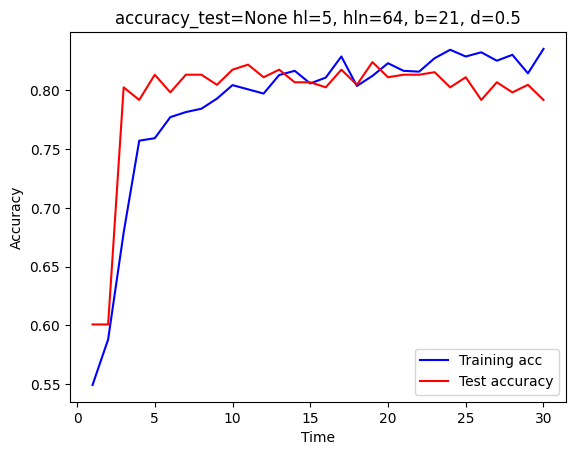

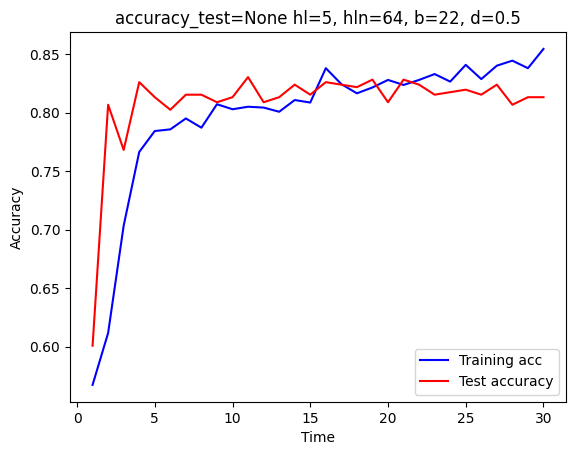

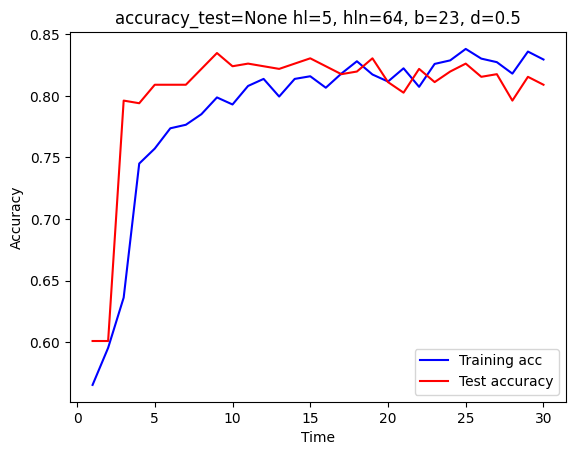

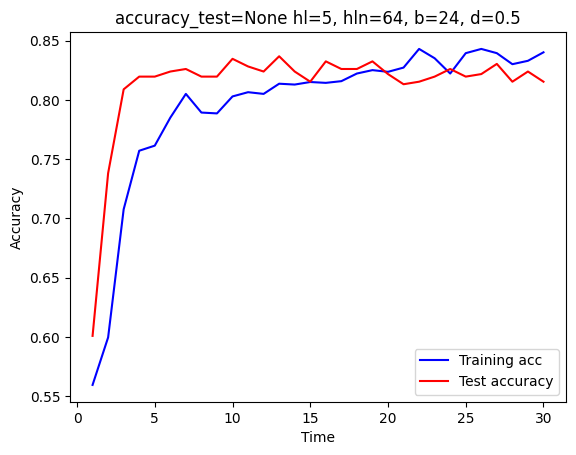

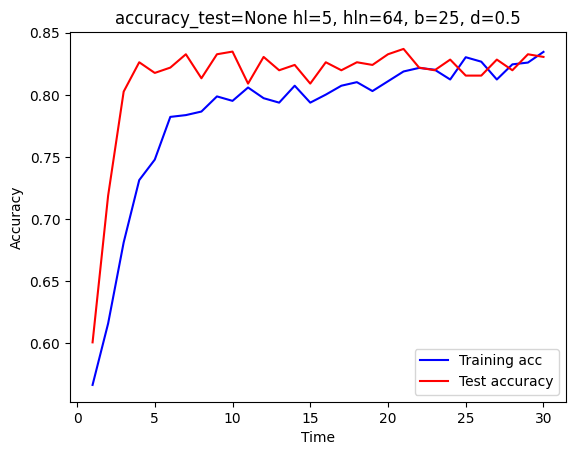

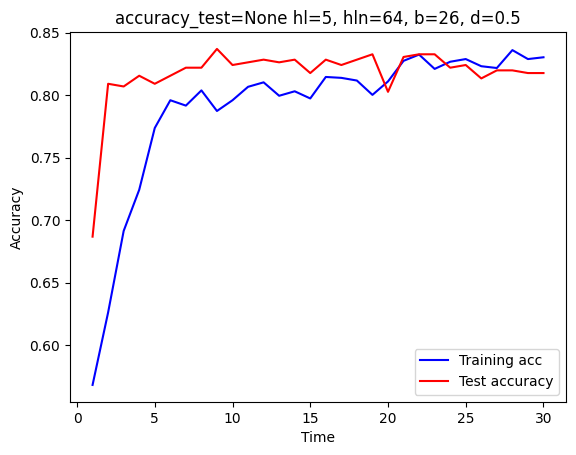

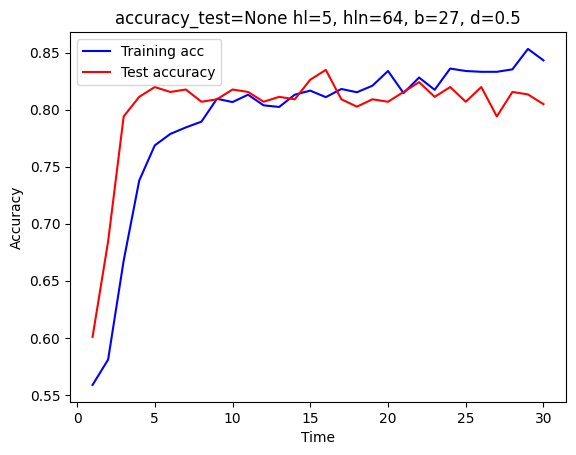

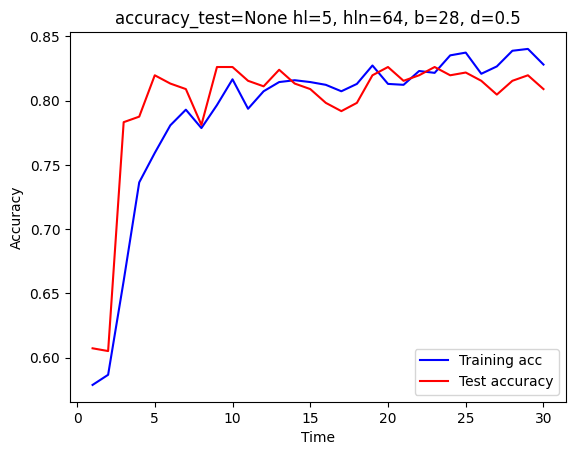

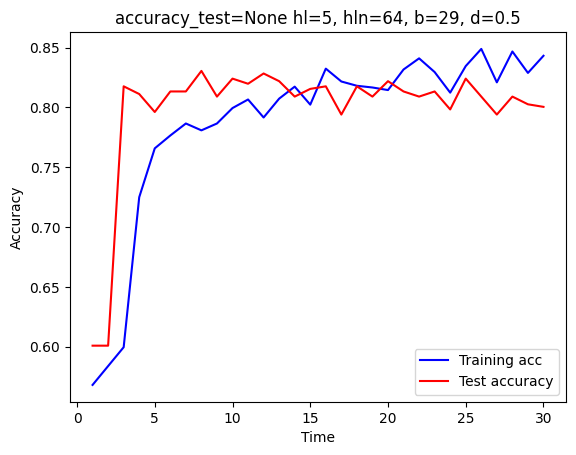

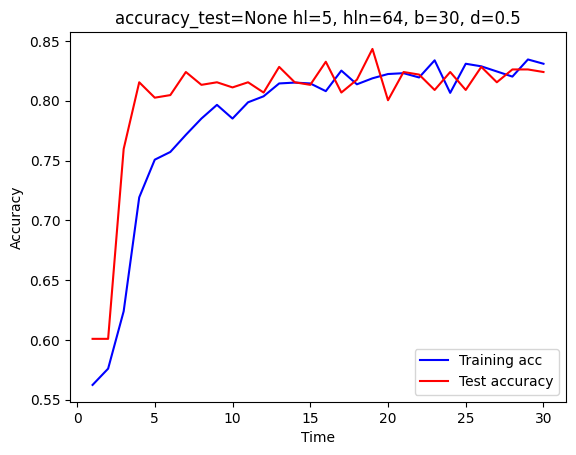

In [34]:
# Parameters
epochs = 30
batch_size=12
hidden_layers=5 
hidden_layer_neurones=64
dropout=0.5
learning_rate=0.003

# Define save checkpoint callback (only save if new best validation results)
checkpoint_cb = keras.callbacks.ModelCheckpoint(
    'model_checkpoint.keras', save_best_only=True)

# Define early stopping callback
# Stop when no validation improvement for 25 epochs
# Restore weights to best validation accuracy
early_stopping_cb = keras.callbacks.EarlyStopping(
    patience=25, restore_best_weights=True)


for batch_size in range(5, 31):
# Define network
    number_features = X_train_sc.shape[1]
    model = make_net(number_features, 
                    hidden_layers=hidden_layers, 
                    hidden_layer_neurones= hidden_layer_neurones, 
                    dropout=dropout, 
                    learning_rate=learning_rate)

    ### Train model (and store training info in history)
    history = model.fit(X_train_sc,
                        y_train,
                        epochs=epochs,
                        batch_size=batch_size,
                        validation_data=(X_test_sc, y_test),
                        verbose=0)

    accuracy_test =  calculate_accuracy(model, X_train_sc, X_test_sc, y_train, y_test)
    plot_training(history.history, 
    title = f"accuracy_test={accuracy_test} hl={hidden_layers}, hln={hidden_layer_neurones}, b={batch_size}, d={dropout}")

   

   

In [1]:
# Parameters
epochs = 30
batch_size=30
hidden_layers=5 
hidden_layer_neurones=64
dropout=0.5
learning_rate=0.003

# Define save checkpoint callback (only save if new best validation results)
checkpoint_cb = keras.callbacks.ModelCheckpoint(
    'model_checkpoint.keras', save_best_only=True)

# Define early stopping callback
# Stop when no validation improvement for 25 epochs
# Restore weights to best validation accuracy
early_stopping_cb = keras.callbacks.EarlyStopping(
    patience=25, restore_best_weights=True)

results = []

for learning_rate in np.arange(0.001, 0.01, 0.001):
    for dropout in np.arange(0.1, 0.6, 0.1):
        for hidden_layer_neurones in range(16, 129, 16):
            for hidden_layers in range(2, 10, 2):
            # Define network
                number_features = X_train_sc.shape[1]
                model = make_net(number_features, 
                                hidden_layers=hidden_layers, 
                                hidden_layer_neurones= hidden_layer_neurones, 
                                dropout=dropout, 
                                learning_rate=learning_rate)

                ### Train model (and store training info in history)
                history = model.fit(X_train_sc,
                                    y_train,
                                    epochs=epochs,
                                    batch_size=batch_size,
                                    validation_data=(X_test_sc, y_test),
                                    verbose=0)

                accuracy_test =  calculate_accuracy(model, X_train_sc, X_test_sc, y_train, y_test)
                results.append({
                    "learning_rate": learning_rate,
                    "dropout": dropout,
                    "hidden_layer_neurones": hidden_layer_neurones,
                    "hidden_layers": hidden_layers,
                    "batch_size": batch_size,
                    "accuracy_test": accuracy_test
                })
                plot_training(history.history, 
                title = f"accuracy_test={accuracy_test:.2f} hl={hidden_layers}, hln={hidden_layer_neurones}, b={batch_size}, d={dropout}")

results_sorted = sorted(results, key=lambda x: x["accuracy_test"], reverse=True)

for result in results_sorted:
    print(result)



NameError: name 'keras' is not defined